# Reset networks - Topography for CIFAR100
**Objective**

Demonstrate the emergence of topography for image classification - CIFAR100

**Means**

Reset network <br>
CIFAR100 dataset <br>

<img src = 'https://github.com/THANNAGA/Reset-Networks/blob/main/Topography%20for%20cifar-100/Approach_cifar_100.png?raw=true' width=700px>



*Figure 1.(A) Reset Networks approach the visual cortex as a sequence of levels that realize different topographic spaces. Each level consists in a grid of deep neural networks sharing the entire input from the level below. The output of the grid then becomes the input to the grid of networks at the next level. **(B)** A Reset network with 2 levels trained on the CIFAR100 dataset.*

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

import torchvision
import torchvision.transforms as transforms
import torch.optim as optim

from PIL import Image
import time
import numpy as np
from numpy.ma import masked_array
from scipy import ndimage
from scipy.signal import convolve2d as conv
from scipy.ndimage import gaussian_filter
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.patches import Rectangle
from matplotlib import gridspec
import sys, math
import pandas as pd
from sklearn.utils import shuffle
import cv2

sys.path.insert(0,'/content/drive/MyDrive/ColabNotebooks/')
from resnet import resnetSmall, resnet18, resnet34, resnet50, resnet101, resnet152 
from resnet_CIFAR10 import resnet20, hresnet20reg

In [4]:
checkpointpath = '/content/drive/MyDrive/ColabNotebooks/'
modelname = 'ResetNumber8'#'ResNet20'
dataset = 'CIFAR100'
train_batchsize = 100
test_batchsize = 100
use_cuda = True
gridsize = 8
n_classes1 = 4*4
n_classes = 100
lrate = 0.001
drop_rate = 0.5
input_channels = 3
load_model = False
load_submodels = False
epochs = 20
num_workers=1

Transforms for data augmentation

In [ ]:
augment_data = False
if augment_data: 
    transform = transforms.Compose(
      [transforms.RandomCrop(32, padding=4),
      transforms.RandomHorizontalFlip(),
      transforms.ToTensor(),
      transforms.Normalize((0.5071, 0.4867, 0.4408), (0.2675, 0.2565, 0.2761))])
    
    transform_w = transforms.Compose(
      [transforms.RandomCrop(32, padding=4),
      transforms.RandomHorizontalFlip(),
      transforms.ToTensor(),
      transforms.Normalize((0, 0, 0), (1, 1, 1))])
else: 
    transform = transforms.Compose(
      [transforms.ToTensor(),
       transforms.Normalize((0.5071, 0.4867, 0.4408), (0.2675, 0.2565, 0.2761))])
    transform_w = transforms.Compose(
      [transforms.ToTensor(),
       transforms.Normalize((0, 0, 0), (1, 1, 1))])

## Load CIFAR100

In [1]:
def load_CIFAR100_classes():
  classes = classes_c = [
            'apple', 
            'aquarium_fish',
            'baby',
            'bear',
            'beaver',
            'bed',
            'bee',
            'beetle',
            'bicycle',
            'bottle',
            'bowl',
            'boy',
            'bridge',
            'bus',
            'butterfly',
            'camel',
            'can',
            'castle',
            'caterpillar',
            'cattle',
            'chair',
            'chimpanzee',
            'clock',
            'cloud',
            'cockroach',
            'couch',
            'crab',
            'crocodile',
            'cup',
            'dinosaur',
            'dolphin',
            'elephant',
            'flatfish',
            'forest',
            'fox',
            'girl',
            'hamster',
            'house',
            'kangaroo',
            'computer_keyboard',
            'lamp',
            'lawn_mower',
            'leopard',
            'lion',
            'lizard',
            'lobster',
            'man',
            'maple_tree',
            'motorcycle',
            'mountain',
            'mouse',
            'mushroom',
            'oak_tree',
            'orange',
            'orchid',
            'otter',
            'palm_tree',
            'pear',
            'pickup_truck',
            'pine_tree',
            'plain',
            'plate',
            'poppy',
            'porcupine',
            'possum',
            'rabbit',
            'raccoon',
            'ray',
            'road',
            'rocket',
            'rose',
            'sea',
            'seal',
            'shark',
            'shrew',
            'skunk',
            'skyscraper',
            'snail',
            'snake',
            'spider',
            'squirrel',
            'streetcar',
            'sunflower',
            'sweet_pepper',
            'table',
            'tank',
            'telephone',
            'television',
            'tiger',
            'tractor',
            'train',
            'trout',
            'tulip',
            'turtle',
            'wardrobe',
            'whale',
            'willow_tree',
            'wolf',
            'woman',
            'worm']
  return classes 

In [ ]:
transform = transforms.Compose(
      [transforms.Resize(32),
      transforms.RandomCrop(32, padding=4),
      transforms.RandomHorizontalFlip(),
      transforms.ToTensor(),
      transforms.Normalize((0.491, 0.482, 0.447), (0.247, 0.243, 0.261))])

trainset = torchvision.datasets.CIFAR100(root='./data', train=True,
                                          download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=train_batchsize,
                                            shuffle=True, num_workers=num_workers)

testset = torchvision.datasets.CIFAR100(root='./data', train=False,
                                        download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=test_batchsize,
                                          shuffle=False, num_workers=1)

classes = load_CIFAR100_classes()
class_total = [np.sum(np.array(trainset.targets) == i) for i in np.arange(100)]
weights = torch.Tensor(np.max(class_total)/np.array(class_total))
print ('CIFAR-100 loaded')

  0%|          | 0/169001437 [00:00<?, ?it/s]

Extracting ./data/cifar-100-python.tar.gz to ./data
Files already downloaded and verified
CIFAR-100 loaded


Reality check

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


classes[index], mean: hamster 0.5281611


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


classes[index], mean: baby -0.09205366
classes[index], mean: bottle -0.3128042
classes[index], mean: tractor -1.0619259
classes[index], mean: aquarium_fish -0.94531137
classes[index], mean: telephone 0.31153357
classes[index], mean: train -1.0690961
classes[index], mean: bear -0.5079902


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


classes[index], mean: aquarium_fish -0.8013956
classes[index], mean: lion -0.17013341


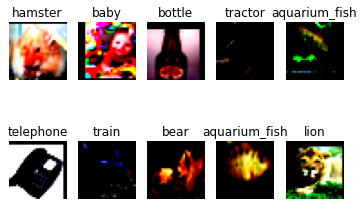

In [ ]:
train_iter = iter(trainloader)
images, labels = train_iter.next()
for i in np.arange(10):
  index = int(labels[i].numpy())
  plt.subplot(2,5,i+1)
  plt.title(classes[index])
  plt.axis('off')
  im = np.moveaxis(images[i].numpy(), 0,2)
  plt.imshow(im)
  print ('classes[index], mean:', classes[index], np.mean(im))
plt.savefig('CIFAR_10.png', dpi = 300)
plt.show()

## Model

In [ ]:
# Reset network for CIFAR10
class Reset(nn.Module):
  def __init__(self, input_channels=3, h1_1=400, gridsize=8, n_classes1=16, n_classes2=10, drop_rate=0.2):
    super(Reset, self).__init__()
    self.gridsize = gridsize
    self.n_classes1 = n_classes1
    self.sqrt_n_classes1 = int(n_classes1**0.5)
    self.Nest1 = nn.ModuleList([resnet20(num_channels=input_channels, num_classes=n_classes1) for i in np.arange(self.gridsize**2)])
    self.Classifier = resnet20(num_channels=1, num_classes=n_classes2)
    self.BN0 = nn.BatchNorm2d(num_features = 1)
    self.dropout = nn.Dropout(drop_rate)
    self.sigmoid = nn.Sigmoid()
    self.tanh = nn.Tanh()
	
  def forward(self, x):
    level1 = [self.Nest1[i](x) for i in np.arange(self.gridsize**2)] #process input through all networks at level 1
    level1 = torch.stack(level1, dim=0)
    level1 = level1.permute(1,2,0)
    # reshape by patch (nested list comprehension probably more elegant)
    to_cat = []
    for j in np.arange(self.gridsize):
      to_cat += [torch.cat([level1[:,:,i].reshape(-1, 1, self.sqrt_n_classes1, self.sqrt_n_classes1) for i in np.arange(j*self.gridsize, (j+1)*self.gridsize)],3)]
    grid = torch.cat(to_cat, 2)
    #grid = self.sigmoid(grid)
    grid = self.tanh(grid)
    grid = self.dropout(grid)
    grid = self.BN0(grid)
    out_c = self.Classifier(grid)
    return grid, out_c

In [ ]:
def load_Model(checkpointpath=None, modelname=None, dataset=None, load_model=False,
               input_channels=input_channels, gridsize=gridsize, n_classes1=n_classes1, n_classes2=n_classes):

  if 'Reset' in modelname:
    net = Reset(input_channels=input_channels, gridsize=gridsize, n_classes1=n_classes1, n_classes2=n_classes)
    print ('Reset network for CIFAR100 loaded')

  if 'ResNet20' in modelname:
    net = hresnet20reg(num_channels=input_channels, num_classes=n_classes)
    print ('ResNet20 loaded')

  model_total_params = sum(p.numel() for p in net.parameters())
  print('==> Model built. The model has ',model_total_params,'total parameters, and ',n_classes,'classes')

  if load_model:
    #load the model
    state = torch.load(checkpointpath + modelname + dataset + 'best_ckpt.t7')
    keys = list(state['net'].keys()); print ('This network had', len(keys),'stored sets of parameters')
    if 'module.' in keys[0]:
      for name in keys:
        state['net'][name[7:]] = state['net'].pop(name)
    net.load_state_dict(state['net'])
    print ('Pretrained weights loaded')

  if load_submodels:
    #load pretrained submodel
    pretrained_dict = submodel.state_dict()
    
    model_dict = model.state_dict()
    # 1. filter out unnecessary keys (remove key for last dense layer)
    pretrained_dict = {k: v for k, v in pretrained_dict.items() if k is not 'fc2'}
    # 2. overwrite entries in the existing state dict
    model_dict.update(pretrained_dict) 
    # 3. load the new state dict
    model.load_state_dict(pretrained_dict)
  
  return net

net = load_Model(checkpointpath=checkpointpath, modelname=modelname, load_model=load_model)

Reset network for CIFAR100 loaded
==> Model built. The model has  17562454 total parameters, and  100 classes


# Training

Parallel computing

In [ ]:
# Parallel computing
device = torch.device("cuda" if use_cuda else "cpu")
print ('device:', device)
net.to(device)
net = torch.nn.DataParallel(net)
weights = weights.to(device)
GPUcount = torch.cuda.device_count()
if GPUcount == 0:
  print ('No GPU available.')
if GPUcount == 1:
  print ('One GPU available.')
if GPUcount > 1:
  print (GPUcount, 'GPUs are available.')
print ('GPU type:', torch.cuda.get_device_name())

device: cuda
One GPU available.
GPU type: Tesla P100-PCIE-16GB


In [ ]:
Adam=True
if Adam:
  criterion = nn.CrossEntropyLoss(weight=weights)
  optimizer = optim.Adam(net.parameters(), lr=lrate)

In [ ]:
Sgd=False
if Sgd:
  criterion = nn.CrossEntropyLoss(weight=weights)
  optimizer = optim.SGD(net.parameters(), lr=lrate, momentum=0.9, weight_decay=5e-4)
  scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)

Testing:

In [ ]:
def test(net):
  net.eval()
  start = time.time()
  net.to(device)
  correct = 0
  total = 0
  with torch.no_grad():
      for data in testloader:
          inputs, targets = data
          inputs, targets = inputs.to(device), targets.to(device)
          grid, outputs = net(inputs)
          testloss = criterion(outputs, targets).item()
          _, predicted = torch.max(outputs.data, 1)
          correct += (predicted == targets).float().sum()
          total += labels.size(0)
  testacc = (100*correct/total).cpu().numpy()
  print('test accuracy of the network on ',total,'test images:',testacc)

  end = time.time()
  print('Test time:', time.strftime('%H:%M:%S', time.gmtime(end-start)))
  print('n')

  return grid, testacc

Compute grid responses and output accuracies for all categories

In [ ]:
def compute_class_grid2(grid, epoch=0, verbose=False):
  n = len(classes)
  if modelname == 'ResNet20':
    gn, gh = grid.shape
    gc = 1
    gs = int(gh**0.5)
  else:
    gn, gc, gs, gs = grid.shape
  print ('gn, gc, gs, gs', gn, gc, gs, gs)
  class_correct = list(0. for i in np.arange(n))
  class_total = list(0. for i in np.arange(n))
  class_grid = np.ones((n, gs, gs))
  with torch.no_grad():
      for data in testloader:
          images, labels = data
          images, labels = images.to(device), labels.to(device)

          grid, outputs = net(images)
          _, predicted = torch.max(outputs.data, 1)

          grid_data = grid.cpu().numpy().squeeze()
          if modelname == 'ResNet20':
            grid_data = np.reshape(grid_data, (-1, gs, gs))

          for i, label in enumerate(labels):
              label = int(label.cpu().numpy())
              if gc > 1:
                class_grid[label] += np.mean(grid[i], axis=0)
              else:
                class_grid[label] += grid_data[i]
              if epoch == 0:
                class_grid[label] += np.random.rand(gs, gs)*1e-3 #This trick avoids retruning a single argmax in case of equal values.
              class_correct[label] += predicted[i].item()
              class_total[label] += 1
  class_acc = np.zeros(n)
  for i in np.arange(n):
      class_acc[i] = 100 * class_correct[i] / class_total[i]
      if class_total[i] > 0:
        class_grid[i] = class_grid[i]/class_total[i]
      if verbose:
        print('%3d Accuracy of %5s : %2d %% (%5d / %5d)' % (i, classes[i], class_acc[i], class_correct[i], class_total[i]))
  return class_acc, class_grid
  
go_compute_class_grid2 = False
if go_compute_class_grid2:
  class_acc, class_grid = compute_class_grid2(grid, verbose=True)

Training

In [ ]:
start = time.time()
e_start = time.time()
ltrain, ltest = len(trainloader), len(testloader)
print ('number of mini-batches for training:', ltrain)
print ('mini-batch size:', train_batchsize)
print ('total number of training exemplars:', ltrain*train_batchsize)
print ('\nnumber of mini-batches for testing:', ltest)
print ('mini-batch size:', test_batchsize)

if load_model:
  test_acc_history = np.load(checkpointpath + modelname + dataset + 'test_acc_history.npy')
  class_acc_history = np.load(checkpointpath + modelname + dataset + 'class_acc_history.npy')
  class_grid_history = np.load(checkpointpath + modelname + dataset + 'class_grid_history.npy')
  last_epoch = len(test_acc_history)
  bestacc = np.max(test_acc_history)
  print ('saved metrics loaded')
else:
  test_acc_history = []
  class_acc_history = []
  class_grid_history = []
  last_epoch = 0
  bestacc = 0

test_every = ltrain//2
#test_every = 2*ltrain   #never test
print_every = ltrain//20
print ('we will test every:', test_every, 'mini-batches, meaning, every',test_every*train_batchsize,'training exemplars.')

# Initial testing before training.
grid, testacc = test(net)
test_acc_history += [testacc]
class_acc, class_grid = compute_class_grid2(grid, verbose=False)
class_acc_history += [class_acc]
class_grid_history += [class_grid]
np.save(checkpointpath + modelname + dataset + 'test_acc_history.npy', test_acc_history)
np.save(checkpointpath + modelname + dataset + 'class_acc_history.npy', class_acc_history)
np.save(checkpointpath + modelname + dataset + 'class_grid_history.npy', class_grid_history)

# Start training
net.train()
for epoch in np.arange(last_epoch + epochs): 
    print ('Epoch:', epoch) 
    running_loss = 0.0
    running_lossAuto = 0.0
    running_lossClass = 0.0
    for i, (inputs, labels) in enumerate(trainloader):
        inputs, labels = inputs.to(device), labels.to(device)
        #print ('labels.size()', labels.size())

        optimizer.zero_grad()
        grid, outputs = net(inputs)
        #print(outputs.size())
        loss = criterion(outputs, labels)

        
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if (i != 0) & (i % print_every == 0):    # print
          print ('[batch %3d] loss:%.3f' % (i, loss.item()))

        if (i != 0) & (i % test_every == 0):    # test 
            e_end = time.time()
            print('\n\nTraining time:', time.strftime('%H:%M:%S', time.gmtime(e_end - e_start)))
            e_start = time.time()

            closs = running_loss / test_every
            print('[%d, %5d] loss:%.3f' % (epoch + 1, i + 1, closs))

            running_loss = 0.0
            _, testacc = test(net)
            test_acc_history += [testacc]
            class_acc, class_grid = compute_class_grid2(grid, epoch=epoch, verbose=False)
            class_acc_history += [class_acc]
            class_grid_history += [class_grid]
            np.save(checkpointpath + modelname + dataset + 'test_acc_history.npy', test_acc_history)
            np.save(checkpointpath + modelname + dataset + 'class_acc_history.npy', class_acc_history)
            np.save(checkpointpath + modelname + dataset + 'class_grid_history.npy', class_grid_history)
            net.train()

            if testacc > bestacc:
              print ('saving as best model')
              state = {'net': net.state_dict(),}
              torch.save(state, checkpointpath + modelname + dataset + 'best_ckpt.t7')
              bestacc = testacc
np.save(checkpointpath + modelname + dataset + 'test_acc_history.npy', test_acc_history)
np.save(checkpointpath + modelname + dataset + 'class_acc_history.npy', class_acc_history)
np.save(checkpointpath + modelname + dataset + 'class_grid_history.npy', class_grid_history)
end = time.time()
print('Done training. Total training time:')
print(time.strftime('%H:%M:%S', time.gmtime(end-start)))

number of mini-batches for training: 500
mini-batch size: 100
total number of training exemplars: 50000

number of mini-batches for testing: 100
mini-batch size: 100
we will test every: 250 mini-batches, meaning, every 25000 training exemplars.
test accuracy of the network on  10000 test images: 0.88
Test time: 00:00:33
n
gn, gc, gs, gs 100 1 32 32
Epoch: 0
[batch  25] loss:4.589
[batch  50] loss:4.408
[batch  75] loss:4.509
[batch 100] loss:4.396
[batch 125] loss:4.272
[batch 150] loss:4.276
[batch 175] loss:4.127
[batch 200] loss:4.066
[batch 225] loss:4.177
[batch 250] loss:4.064


Training time: 00:08:48
[1,   251] loss:4.386
test accuracy of the network on  10000 test images: 6.06
Test time: 00:00:33
n
gn, gc, gs, gs 100 1 32 32
saving as best model
[batch 275] loss:3.998
[batch 300] loss:4.067
[batch 325] loss:3.983
[batch 350] loss:3.932
[batch 375] loss:3.720
[batch 400] loss:3.880
[batch 425] loss:3.679
[batch 450] loss:3.978
[batch 475] loss:4.045
Epoch: 1
[batch  25] loss:3.

## CIFAR-100 topography

Cifar-100 cluster visualization

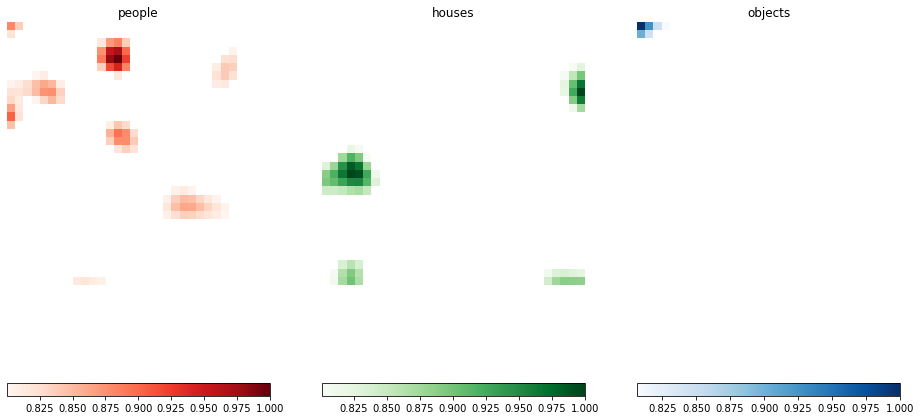

In [ ]:
from scipy.ndimage import gaussian_filter
from numpy.ma import masked_array
titles = ['people', 'houses', 'objects']
maps = ['Reds', 'Greens', 'Blues']
#indices of target classes in CIFAR-100:
ranges = [np.array([2, 11, 35, 46, 98]), np.array([17, 37, 76]), np.array([9, 10, 16, 20, 22])]
l = len(titles)
T = 0.8 #significance threshold, with t-value.
gf_sigma = 2.0
fig = plt.figure(figsize=(16, 12)) 
for i, (title, range, map) in enumerate(zip(titles, ranges, maps)):
  plt.subplot(1,l,i+1)
  plt.title(title)
  data = np.mean(class_grid[range], axis=0) # average over target classes
  data -= np.mean(class_grid, axis=0)       # contrast with all classes
  data = gaussian_filter(data, sigma = gf_sigma)   # smoothing
  data = (data - np.min(data))/(np.max(data) - np.min(data)) # rescaling
  data = masked_array(data, data < T)
  plt.imshow(data, cmap=plt.get_cmap(map))
  plt.colorbar(orientation = 'horizontal')
  plt.axis('off')
plt.savefig(checkpointpath + 'maps_' + modelname + dataset +'.png')
plt.show()

In [6]:
import math

def clustering_index2(data, threshold=0.85, connectivity=4):
  den_index = np.sum(data)
  data = (data > threshold).astype(np.uint8)
  ret, thresh = cv2.threshold(data, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
  num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(thresh, connectivity, cv2.CV_32S)
  clu_index = np.mean(stats[1:,-1])
  if math.isnan(clu_index):
    clu_index = 1 #minimal cluster size

  return num_labels, labels, clu_index

def compute_pipeline2(select1, select2, T = 1, connectivity = 8, gf_sigma=0, show=False):
  # compute d-prime sensitivity measure at each point of the grid
  mean1 = np.mean(select1, axis=0)
  mean2 = np.mean(select2, axis=0)
  std1 = np.var(select1, axis=0)**0.5
  std2 = np.var(select2, axis=0)**0.5

  # possibly smooth activations
  smean1 = gaussian_filter(mean1, sigma = gf_sigma)   # smoothing
  smean2 = gaussian_filter(mean2, sigma = gf_sigma)   

  # compute d-prime map
  dmap = 2*(smean1 - smean2)/(std1 + std2)

  # compute clustering index
  _, _, clu_index = clustering_index2(dmap, threshold=T, connectivity=connectivity)

  # compute control clustering index
  clu_index_ctrl = 0
  power = 20
  for k in np.arange(10):
    dmapshuf = np.ravel(np.copy(dmap))
    np.random.shuffle(dmapshuf)
    dmapshuf = np.reshape(dmapshuf, dmap.shape)
    _, _, ctrl_clu = clustering_index2(dmapshuf, threshold=T, connectivity=connectivity)
    clu_index_ctrl += ctrl_clu
  clu_index_ctrl = clu_index_ctrl/float(power)

  # return variables
  targets_data = dmap #> T

  density = np.sum(smean1)
  if show:
    plt.figure(figsize=(10,10))
    plt.subplot(141);plt.imshow(mean1);plt.title('mean1');plt.axis('off')
    plt.subplot(142);plt.imshow(mean2);plt.title('mean2');plt.axis('off')
    plt.subplot(143);plt.imshow(dmap);plt.title('dprimes 1-2');plt.axis('off');plt.colorbar(orientation='horizontal')
    plt.subplot(144);plt.imshow(dmap>T);plt.title('clustering:'+str(clu_index)[:5]);plt.axis('off');plt.colorbar(orientation='horizontal')
    plt.show()
    return stop_error
  
  return targets_data, clu_index, clu_index_ctrl, density

def compute_save_metrics2(modelname=None, dataset=None, T=2, S=0, nopref=False):
  # load data history
  class_acc_history = np.load(checkpointpath + modelname + dataset + 'class_acc_history.npy')
  #print ('class_acc_history.shape',class_acc_history.shape)
  class_grid_history = np.load(checkpointpath + modelname + dataset + 'class_grid_history.npy')
  #print ('class_grid_history.shape',class_grid_history.shape)

  # define macro-classes
  titles = ['people', 'houses', 'objects']
  maps = ['Reds', 'Greens', 'Blues']
  #indices of target classes in CIFAR-100:
  ranges = [[2, 11, 35, 46, 98], [17, 37, 76], [9, 10, 16, 20, 22]]
  all_ranges = np.arange(100)

  # initialize arrays
  n_epochs,_,x,y = np.shape(class_grid_history)
  n_classes = len(ranges)
  target_maps_history = np.zeros((n_epochs, n_classes, x, y))
  clustering_history = np.zeros((n_epochs, n_classes))
  clustering_history_ctrl = np.zeros((n_epochs, n_classes))
  density_history = np.zeros((n_epochs, n_classes))
  target_acc_history = np.zeros((n_epochs, n_classes))

  # setting parameters for sensitivity and clustering analysis
  connectivity = 4

  # consider a contrast between two sets of classes, here animals vs objects
  
  #sets1 = np.arange(lc)
  #sets2 = np.array([[j for j in sets1 if i != j] for i in sets1])
  sets1 = ranges
  sets2 = [[j for j in all_ranges if j not in sublist] for sublist in sets1]
  
  # compute
  for epoch in np.arange(n_epochs):
    print ('analyzing data from epoch', epoch)
    for cat, (set1, set2) in enumerate(zip(sets1, sets2)):
      #print ('cat', cat)
      #print ('set1', set1)
      #print ('set2', set2)
      select1 = class_grid_history[epoch, np.array(set1)]
      select2 = class_grid_history[epoch, np.array(set2)]
      
      targets_data, clustering, clustering_ctrl, density = compute_pipeline2(select1, select2, T = T, connectivity = connectivity, gf_sigma=S, show=False)

      target_maps_history[epoch, cat] = targets_data
      clustering_history[epoch, cat] = clustering
      clustering_history_ctrl[epoch, cat] = clustering_ctrl
      density_history[epoch, cat] = density
      target_acc_history[epoch, cat] = np.mean(class_acc_history[epoch,set1])

  # create label maps. This makes a lot of sense for numerosity, since we've got a clear number line.
  
  if nopref:
    # label -1 will stand for "no preference", when all d-primes are below thresholds
    # we achieve that by concatenating a no preference map before the d-prime maps, filled with a high value.
    # then we remove 1 to all the labels.
    label_maps_history = np.zeros((n_epochs,x,y))
    for epoch, target_maps in enumerate(target_maps_history):
      thres_data = (target_maps<T)
      #print ('thres_data.shape',thres_data.shape)
      #indices_no_pref = (np.sum(thres_data, axis=0) == lc)
      indices_no_pref = (np.sum(thres_data, axis=0) == n_classes)
      #print ('indices_no_pref.shape',indices_no_pref.shape)
      #print ('indices_no_pref', indices_no_pref)
      #plt.imshow(indices_no_pref);plt.show()
      #print ('indices_no_pref', indices_no_pref)
      no_pref = 100*indices_no_pref
      #plt.imshow(no_pref);plt.show()
      no_pref = np.expand_dims(no_pref, axis=0)
      #print ('no_pref.shape',no_pref.shape)
      target_maps = np.concatenate((no_pref, target_maps))
      #print ('target_maps.shape',target_maps.shape)
      label_maps = np.argmax(target_maps, axis=0) - 1
      #print ('label_maps.shape, min, max',label_maps.shape, label_maps.min(), label_maps.max())
      #plt.imshow(label_maps);plt.colorbar();plt.show()
      label_maps_history[epoch] = label_maps
    masked_array(label_maps_history, label_maps_history < 0)
    #plt.imshow(masked_array(label_maps, label_maps < 0));plt.colorbar();plt.show()

    #save
    np.save(checkpointpath + modelname + dataset + 'target_acc_history.npy', target_acc_history)
    np.save(checkpointpath + modelname + dataset + 'target_maps_history.npy', target_maps_history) 
    np.save(checkpointpath + modelname + dataset + 'label_maps_history_nopref.npy', label_maps_history)
    np.save(checkpointpath + modelname + dataset + 'density_history.npy', density_history)
    np.save(checkpointpath + modelname + dataset + 'clustering_history.npy', clustering_history)
    np.save(checkpointpath + modelname + dataset + 'clustering_history_ctrl.npy', clustering_history_ctrl)

  else:
    label_maps_history = np.argmax(target_maps_history, axis=1)
    
    #save
    np.save(checkpointpath + modelname + dataset + 'target_acc_history.npy', target_acc_history)
    np.save(checkpointpath + modelname + dataset + 'target_maps_history.npy', target_maps_history) 
    np.save(checkpointpath + modelname + dataset + 'label_maps_history.npy', label_maps_history)
    np.save(checkpointpath + modelname + dataset + 'density_history.npy', density_history)
    np.save(checkpointpath + modelname + dataset + 'clustering_history.npy', clustering_history)
    np.save(checkpointpath + modelname + dataset + 'clustering_history_ctrl.npy', clustering_history_ctrl)

In [21]:
def animate_numerosity(T=None, S_map = None, save=True, nopref=False):
  import numpy as np
  from numpy.ma import masked_array
  import matplotlib.pyplot as plt
  from matplotlib import animation, rc
  from IPython.display import HTML
  from scipy.stats import describe

  test_acc_history = np.load(checkpointpath + modelname + dataset + 'test_acc_history.npy')
  target_acc_history = np.load(checkpointpath + modelname + dataset + 'target_acc_history.npy')
  density_history = np.load(checkpointpath + modelname + dataset + 'density_history.npy')
  clustering_history = np.load(checkpointpath + modelname + dataset + 'clustering_history.npy')
  clustering_history_ctrl = np.load(checkpointpath + modelname + dataset + 'clustering_history_ctrl.npy')

  if nopref:
    label_maps_history = np.load(checkpointpath + modelname + dataset + 'label_maps_history_nopref.npy')
  else:
    label_maps_history = np.load(checkpointpath + modelname + dataset + 'label_maps_history.npy')

  print ('label_maps_history.shape, min, max',label_maps_history.shape, label_maps_history.min(), label_maps_history.max())
  epoch, x, y = label_maps_history.shape

  target_acc_history = np.median(target_acc_history, axis=1)
  density_history = np.median(density_history, axis=1)
  clustering_history = np.median(clustering_history, axis=1)
  clustering_history_ctrl = np.median(clustering_history_ctrl, axis=1)


  epochs = np.arange(epoch)
  nans = np.nan*np.zeros(epoch)
  acc_lines, clu_lines, clu_ctrl_lines, den_lines = [[]], [[]], [[]], [[]]
  titles = ['people', 'houses', 'objects']
  l = len(titles)

  fig = plt.figure(figsize=(12, 12)) 
  ncols, nrows = 15, 15
  gs = gridspec.GridSpec(nrows, ncols, left=0.05, bottom=0.05, right=0.95, top=0.95, wspace=2, hspace=10)
  plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.1, hspace=None)
  # Add axes which can span multiple grid boxes
  ax0 = fig.add_subplot(gs[:3, :5])
  ax1 = fig.add_subplot(gs[:3, 5:10])
  ax2 = fig.add_subplot(gs[:3, 10:15])
  ax3 = fig.add_subplot(gs[3:, :15])

  #plt.suptitle(modelname+' '+dataset, size=25)
  ax0.set_title('Test accuracy', size=20)
  ax0.set_xlabel('Epochs', size=13) 
  ax0.set_xlim(0, epoch+1)
  
  #ax1.set_title('clustering index', size=20)
  ax1.set_title('Cluster size', size=20)
  ax1.set_xlabel('Epochs', size=13)
  ax1.set_xlim(0,epoch+1)
  
  ax2.set_title('Density index', size=20)
  #ax2.set_title('Density', size=20)
  ax2.set_xlabel('Epochs', size=13)
  ax2.set_xlim(0,epoch+1)
  
  ax3.set_title('Epoch 0', size=20, y=-0.07)
  ax3.tick_params(
          axis='x',          # changes apply to the x-axis
          which='both',      # both major and minor ticks are affected
          bottom=False,      # ticks along the bottom edge are off
          top=False,         # ticks along the top edge are off
          labelbottom=False) # labels along the bottom edge are off
  ax3.tick_params(
          axis='y',          # changes apply to the x-axis
          which='both',      # both major and minor ticks are affected
          left=False,      # ticks along the bottom edge are off
          right=False,         # ticks along the top edge are off
          labelleft=False) # labels along the bottom edge are off
  
  MAX = np.max(label_maps_history)
  smooth = True
  sigma_curves = 1
  if smooth:
    target_acc_history = ndimage.gaussian_filter1d(target_acc_history, sigma_curves, axis=0)
    clustering_history = ndimage.gaussian_filter1d(clustering_history, sigma_curves, axis=0)
    clustering_history_ctrl = ndimage.gaussian_filter1d(clustering_history_ctrl, sigma_curves, axis=0)
    density_history = ndimage.gaussian_filter1d(density_history, sigma_curves, axis=0)
  
  rescale = True
  min_acc, max_acc = np.min(target_acc_history), np.max(target_acc_history)
  min_clu = np.min((np.min(clustering_history), np.min(clustering_history_ctrl))) 
  max_clu = np.max((np.max(clustering_history), np.max(clustering_history_ctrl)))
  min_den, max_den = np.min(density_history), np.max(density_history)
  if rescale:
    target_acc_history = 100*(target_acc_history - min_acc) / (max_acc - min_acc)
    clustering_history = (clustering_history - min_clu) / (max_clu - min_clu)
    clustering_history_ctrl = (clustering_history_ctrl - min_clu) / (max_clu - min_clu)
    density_history = (density_history - min_den) / (max_den - min_den)
    ax0.set_ylim(0,105) 
    ax1.set_ylim(0,1.05)
    ax2.set_ylim(0,1.05)
  else:
    ax0.set_ylim(np.floor(min_acc), np.ceil(max_acc)) 
    ax1.set_ylim(0, np.ceil(max_clu))
    ax2.set_ylim(min_den, np.ceil(max_den))


  max = 2; min = 0
  cmap = plt.get_cmap('gist_rainbow', max+1-min)
  color = 'black'
  # plot: accuracy
  acc_lines[0], = ax0.plot([], [], color=color, lw=2)
  # plot: clustering
  clu_lines[0], = ax1.plot([], [], color=color, label='normal', lw=2)
  # plot: clustering ctrl
  clu_ctrl_lines[0], = ax1.plot([], [], color='gray', label='shuffled', lw=2);ax1.legend(frameon=False)
  # plot: density
  den_lines[0], = ax2.plot([], [], color=color, lw=2)
  # plot: common map
  data = label_maps_history[0]
  images = ax3.imshow(data, alpha=0.7, cmap=plt.get_cmap(cmap), vmin = min -.5, vmax = max +.5)
  
  cb = plt.colorbar(images, ticks=np.arange(min, max+1), pad=0.01)
  cb.set_ticklabels(titles)
  cb.ax.set_ylabel('class preference', size=20)
  
  # initialization function: plot the background of each frame
  def init():
    acc_lines[0].set_data([], [])
    clu_lines[0].set_data([], [])
    clu_ctrl_lines[0].set_data([], [])
    den_lines[0].set_data([], [])
    images.set_array(label_maps_history[0])
    return acc_lines+clu_lines+clu_ctrl_lines+den_lines+[images]
  
  # animation function. This is called sequentially  
  def animate(t):
    ax3.clear()
    ax3.set_title('epoch '+str(t), size=20, y=-0.07)
    acc_lines[0].set_data(epochs[:t+1], target_acc_history[:t+1])
    clu_lines[0].set_data(epochs[:t+1], clustering_history[:t+1])
    clu_ctrl_lines[0].set_data(epochs[:t+1], clustering_history_ctrl[:t+1])
    den_lines[0].set_data(epochs[:t+1], density_history[:t+1])
    update_data = label_maps_history[t]
    update_data = gaussian_filter(update_data, sigma = S_map)
    images = ax3.imshow(masked_array(update_data, update_data < 0), alpha=0.7, cmap=plt.get_cmap(cmap), vmin = min -.5, vmax = max +.5)
    return acc_lines+clu_lines+clu_ctrl_lines+den_lines+[images]

  frames = np.min((100, epoch))
  anim = animation.FuncAnimation(fig, animate, init_func=init, frames=frames, interval=100, blit=True)

  if save:
    anim.save(filename='history_monitor_'+modelname+'_'+dataset+'.mp4', fps=5, dpi=300)

  # Note: below is the part which makes it work on Colab
  rc('animation', html='jshtml')
  return anim

density_history.shape (21, 3)
density_history [[-32.7955893  -29.10260669 -32.22706838]
 [ 26.27916508  16.72906003  27.43251483]
 [ 44.92052352  26.83388898  35.13178401]
 [ 65.43953415  36.00051479  46.9817017 ]
 [ 74.60033034  25.30672303  50.30534139]
 [ 82.46363983  27.52854809  54.40310372]
 [ 65.49654563  10.66662419  36.93241643]
 [ 45.84212999 -19.39254874   3.65846715]
 [ 44.10346648 -27.37782663  15.57059558]
 [  9.04453804 -58.1320708  -16.06749343]
 [ 32.13885984 -37.52567782  -2.5539761 ]
 [ 18.81378584 -51.58683788 -23.013352  ]
 [ 61.43287535  -5.26241361  21.50243971]
 [ 80.64786052  -9.93064226  33.61798532]
 [ 58.37144869 -33.56664803  16.37334231]
 [ 26.74293118 -41.22293283 -10.81355801]
 [ 34.4562168  -54.26772021  -5.8659246 ]
 [ 47.17516448 -40.56536443   1.43315468]
 [ 53.59391095 -35.24057834   9.92961339]
 [ 98.51161222  15.59891049  58.97721755]
 [105.71755277  12.17619886  64.6465509 ]]
label_maps_history.shape, min, max (21, 32, 32) -1.0 2.0


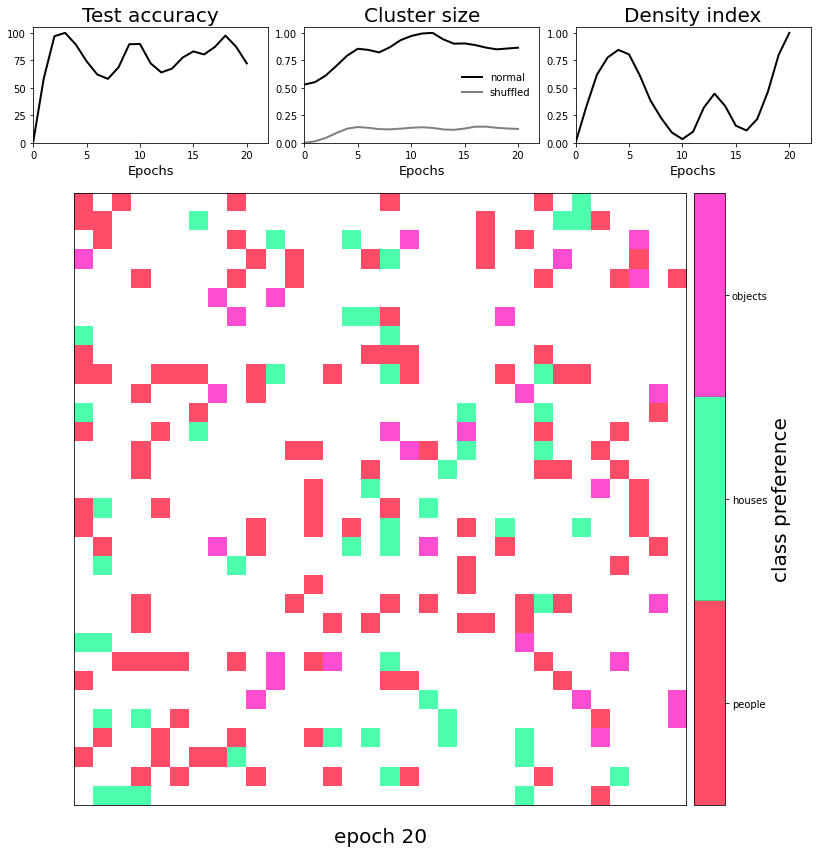

In [22]:
checkpointpath = '/content/drive/MyDrive/ColabNotebooks/'
#modelnames = ['ResetNumber1','ResetNumber2','ResetNumber4','ResetNumber8']
#datasets = 4*['Numbers10']

#modelnames = ['ResetNumber1','ResetNumber2','ResetNumber4','ResetNumber8']
modelnames = ['ResetNumber1']
datasets = 4*['CIFAR100']
threshold = 2.0
smoothing = 0
map_smoothing = 0.
nopref = True
for i, (modelname, dataset) in enumerate(zip(modelnames, datasets)): 
  #compute_save_metrics2(modelname=modelname, dataset=dataset, T=threshold, S=smoothing, nopref=nopref)
  animate_numerosity(T=threshold, S_map = map_smoothing, nopref=nopref)


# Conclusions

Is there topography for CIFAR100 ? <br>
Not really, but there is clustering. In these networks:<br>
1. Units with the same macro-category preference are more likely than chance to be connected on the map (quantified with clustering index).<br>
2. Clustering increases with the number of subnetworks. Subnetworks appear to specialize for different numbers.